In [2]:
import numpy as np
import pandas as pd
import pdb
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal

FIELD_SIZE, FIELD_SPREAD, FIELD_POS_X, FIELD_POS_Y = 0,1,2,3

def gauss2d(size=[80,80], k=0.15):
    w, h = size[0], size[1]
    x, y = np.linspace(0, w, w), np.linspace(0, h, h)
    x, y = np.meshgrid(x, y)
    x_, y_ = x.flatten(), y.flatten()
    xy = np.vstack((x_, y_)).T
    std = [size[0]*k, size[1]*k] # standard deviation, hardcoded based on SIZE, change this as needed 
    normal_rv = multivariate_normal([size[0]/2,size[1]/2], [std[0]**2,std[1]**2]) 
    z = normal_rv.pdf(xy)
    z = z.reshape(w, h, order='F')
    rescaled_z = np.interp(z, (z.min(), z.max()), (0, 25)) # our legacy code assumes max_diff_field = 25
    return rescaled_z

DEFAULT_DIFFUSION_CONFIG = {'dx':1.0, 'dy':1.0, 'dt':0.25, 'vx':0, 'vy':0, 'k':1}
def update_diffusion_field(field, cfg=DEFAULT_DIFFUSION_CONFIG):
    updated_u = field.copy()
    u_k = field.copy()
    for i in range(1, field.shape[0] - 1):
        for j in range(1, field.shape[1] - 1):
            updated_u[j, i] = u_k[j, i] + cfg['k'] * (cfg['dt'] / cfg['dx'] ** 2) * \
                ((u_k[j + 1, i] + u_k[j - 1, i] +
                  u_k[j, i + 1] + u_k[j, i - 1] - 4 * u_k[j, i])) + \
                cfg['vx'] * (cfg['dt'] / cfg['dx']) * ((u_k[j + 1, i] - u_k[j, i])) + cfg['vy'] * (cfg['dt'] / cfg['dy']) * \
                (u_k[j, i + 1] - u_k[j, i])
    return updated_u

def generate_env_map(field_configs, diffuse_config=DEFAULT_DIFFUSION_CONFIG, size=100, n_step=300):
    env_map = np.zeros((n_step,size,size))
    isolated_maps = np.zeros((len(field_configs),size,size))
    metadata = []
    for idx, config in enumerate(field_configs):
        field = gauss2d(size=(config[FIELD_SIZE],config[FIELD_SIZE]), k=config[FIELD_SPREAD])
        x_start, x_end = size+config[FIELD_POS_X]-config[FIELD_SIZE]//2, size+config[FIELD_POS_X]+config[FIELD_SIZE]//2
        y_start, y_end = size+config[FIELD_POS_Y]-config[FIELD_SIZE]//2, size+config[FIELD_POS_Y]+config[FIELD_SIZE]//2
        # generate isolated map for current field
        padded_isolated_map = np.zeros((3*size, 3*size)) # same effect as padding env_map
        padded_isolated_map[y_start:y_end, x_start:x_end]=field
        isolated_maps[idx] = padded_isolated_map[size:size*2,size:size*2]
        # update environment map with current field
        padded_env_map = np.pad(env_map[0], [(size, size), (size, size)], mode='constant')
        padded_env_map[y_start:y_end, x_start:x_end]+=field
        env_map[0] = padded_env_map[size:size*2,size:size*2]
        # generate snapshots of diffusion update for env map
        for i in range(1, n_step):
            env_map[i] = update_diffusion_field(env_map[i-1], cfg=diffuse_config)
        # update field record list
        metadata.append({'position': [config[FIELD_POS_X],config[FIELD_POS_Y]]})
    return env_map, isolated_maps, metadata

In [3]:
map_configs = {
    '1-src-1': [[100,0.18,50,50]],
    '1-src-2': [[80,0.16,30,70]],
    '1-src-3': [[160,0.16,90,10]],
    '2-src-1': [[120,0.16,20,20],[120,0.16,80,80]],
    '2-src-2': [[80,0.16,50,20],[80,0.16,50,80]],
    '2-src-3': [[120,0.16,20,20],[80,0.16,50,80]],
    '2-src-4': [[80,0.16,20,80],[160,0.16,90,10]],
    '2-src-5': [[80,0.16,40,80],[80,0.16,80,40]],
    '3-src-1': [[120,0.16,10,10],[120,0.16,50,90],[120,0.16,90,10]],
    '3-src-2': [[80,0.16,40,40],[80,0.16,80,80],[80,0.16,90,10]],
    '3-src-3': [[80,0.16,50,50],[80,0.16,10,90],[80,0.16,90,10]],
    '3-src-4': [[160,0.16,50,5],[80,0.16,30,80],[80,0.16,80,70]],
    '3-src-5': [[80,0.16,20,20],[80,0.16,80,80],[80,0.16,30,80]],
    '4-src-1': [[80,0.16,10,10],[80,0.16,90,10],[80,0.16,90,90],[80,0.16,10,90]],
    '4-src-2': [[80,0.15,50,10],[80,0.15,50,90],[120,0.16,5,50],[120,0.16,95,50]],
}

In [11]:
import pickle
from collections import OrderedDict

maps = OrderedDict()
for map_name, map_config in map_configs.items():
    env_map, isolated_maps, sources = generate_env_map(map_config)
    maps[map_name] = {'snapshots': env_map, 'isolated_fields': isolated_maps, 'sources': sources, 'metadata': DEFAULT_DIFFUSION_CONFIG}
    
with open('./maps.pickle', 'wb') as handle:
    pickle.dump(maps, handle, protocol=pickle.HIGHEST_PROTOCOL)

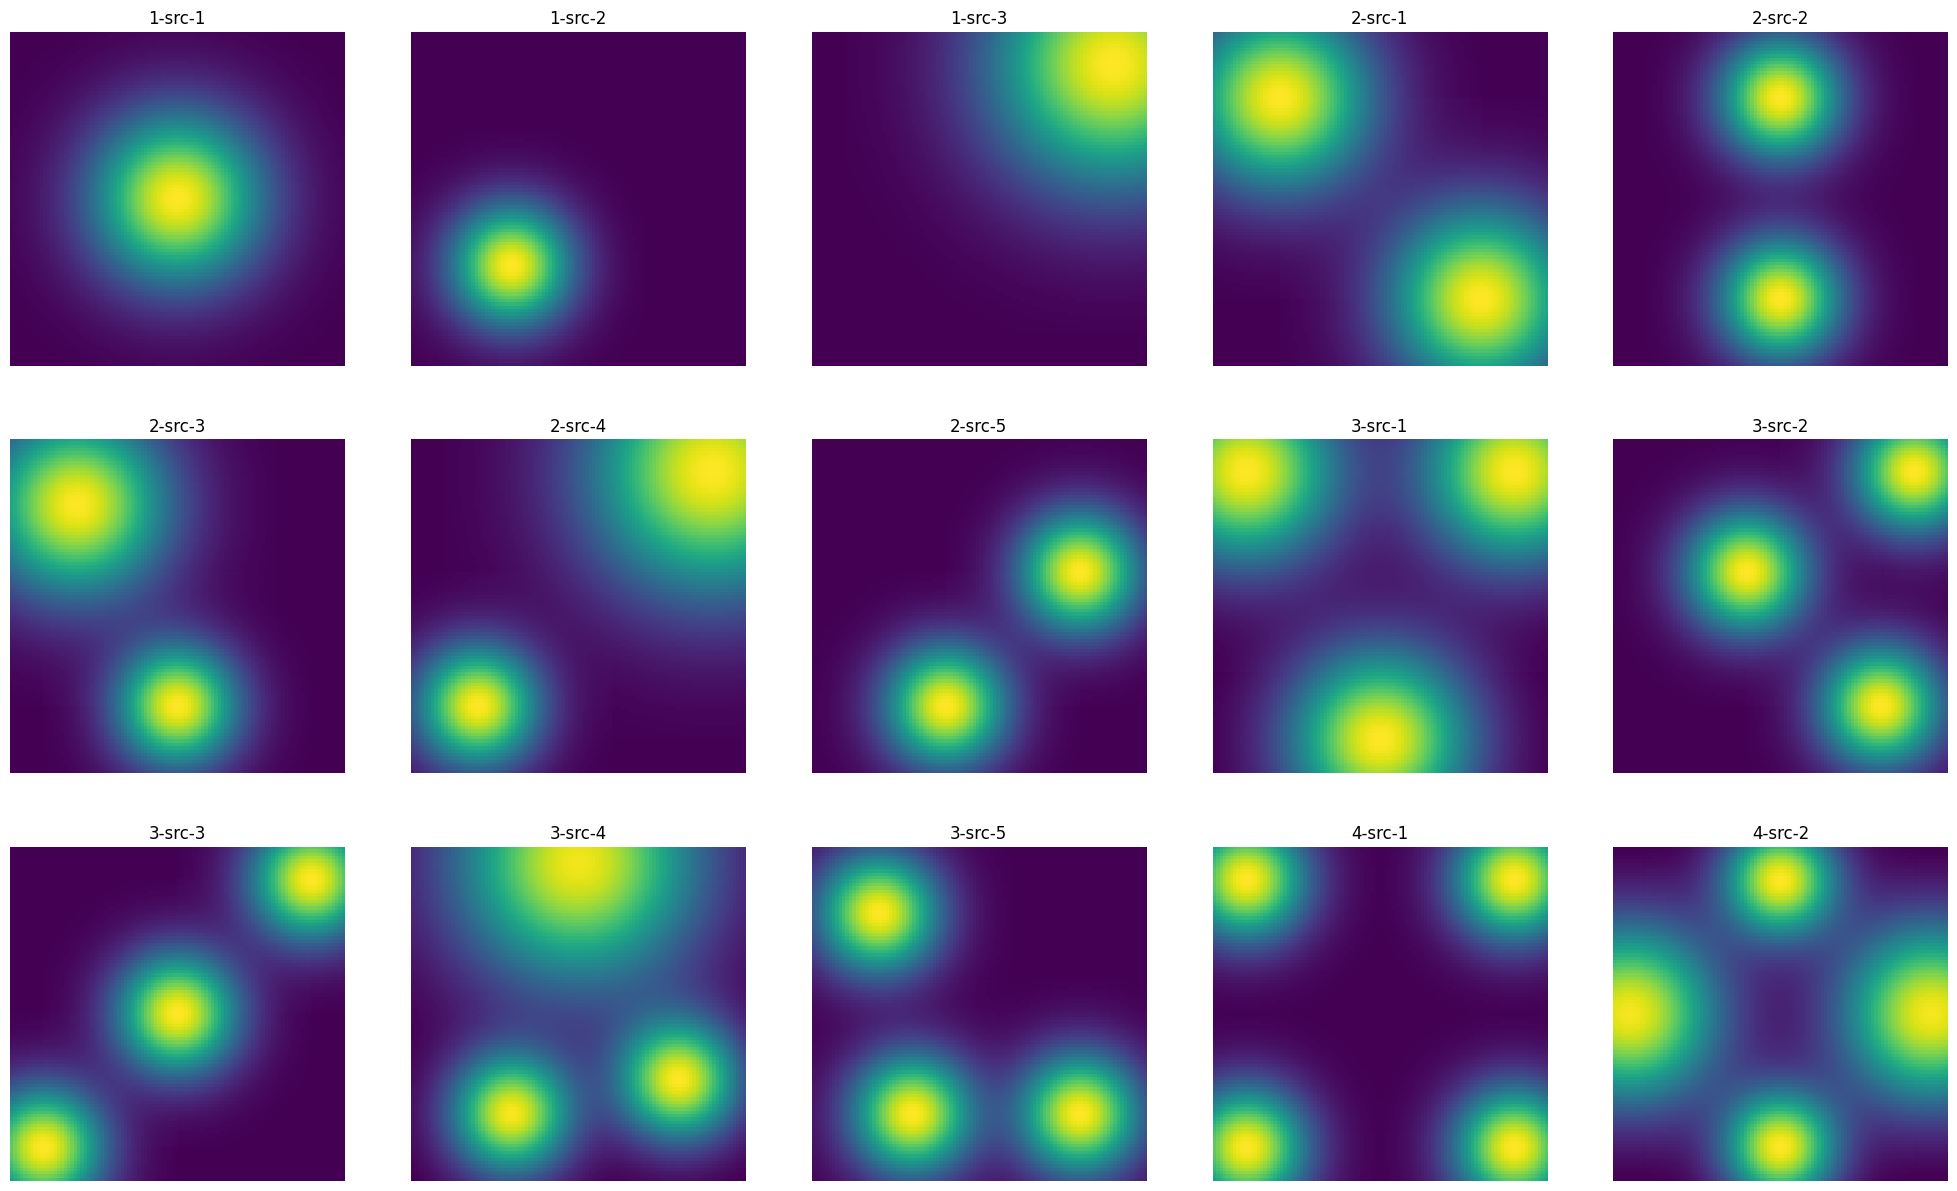

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(maps)//5, 5, figsize=(25, 15))
for idx, name in enumerate(maps.keys()):
    axes[idx//5,idx%5].imshow(maps[name]['snapshots'][0])
    axes[idx//5,idx%5].set_title(name)
    axes[idx//5,idx%5].axis("off")
plt.show()

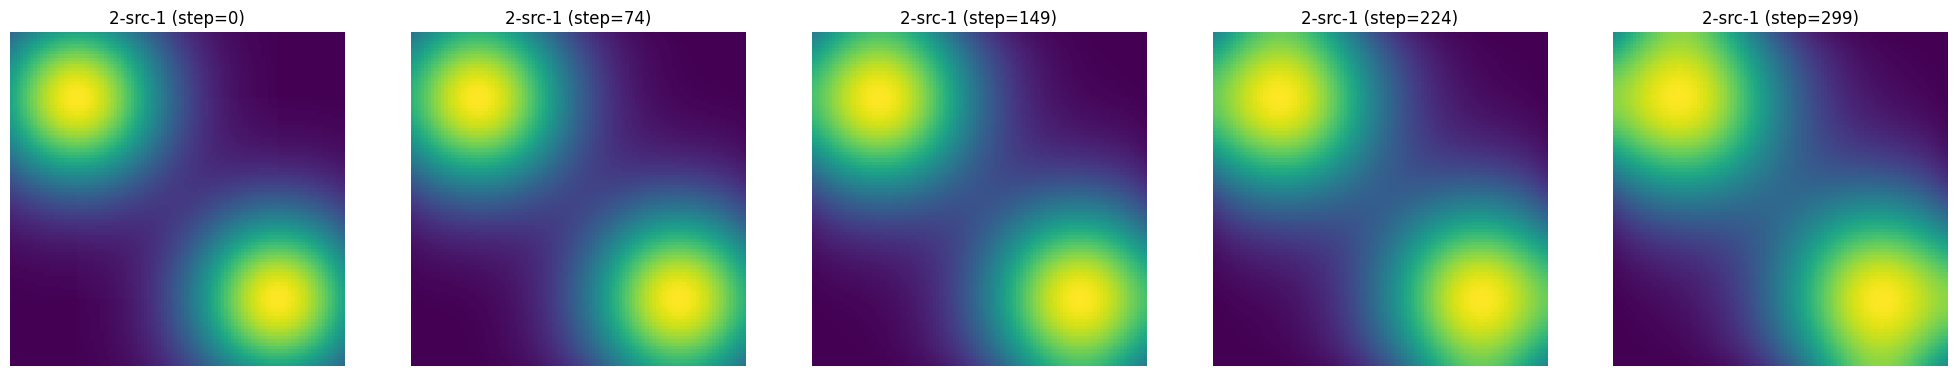

In [13]:
# select map for preview
name = '2-src-1'

with open('./maps.pickle', 'rb') as handle:
    maps = pickle.load(handle)
snapshots = maps[name]['snapshots']

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for i in range(5):
    n = int((len(snapshots)-1)*i/4)
    axes[i].imshow(snapshots[n])
    axes[i].set_title(f"{name} (step={n})")
    axes[i].axis("off")
plt.show()

## Training Source Position Predictor

### 1. Collecting Synthetic Data

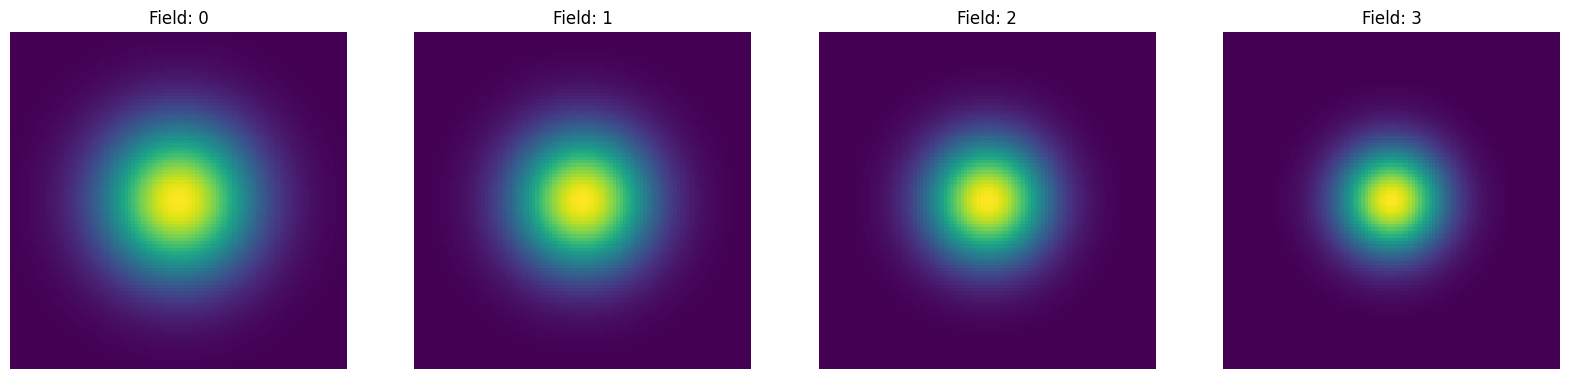

In [14]:
map_configs = [[[100,0.16,50,50]],[[90,0.16,50,50]],[[80,0.16,50,50]],[[70,0.16,50,50]]]
training_maps = []
for map_config in map_configs:
    env_map, isolated_maps, sources = generate_env_map(map_config)
    training_maps.append({'snapshots': env_map, 'isolated_fields': isolated_maps, 'sources': sources, 'metadata': DEFAULT_DIFFUSION_CONFIG})   
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for idx, training_map in enumerate(training_maps):
    axes[idx].imshow(training_map['snapshots'][0])
    axes[idx].set_title(f"Field: {idx}")
    axes[idx].axis("off")
plt.show()

with open('./training_maps.pickle', 'wb') as handle:
    pickle.dump(maps, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
def generate_training_data(maps, sizes=[10], min_thresh=0.3):
    X, Y = [], []
    for map_idx, env_map in enumerate(maps):
        field = env_map['snapshots'][0] # initial field of 1-src-1
        height, width = field.shape
        src_pos = env_map['sources'][0]['position']
        for size in sizes:
            for i in range(1,width-size-1):
                for j in range(1,height-size-1):
                    formation = np.array([[i,j], [i+size,j], [i+size,j+size], [i,j+size]])
                    center = [i+size//2,j+size//2]
                    x = [center[0], center[1], map_idx, size]
                    for pos in formation:
                        if (field[pos[1],pos[0]]<min_thresh):
                            continue
                        x.append(field[pos[1],pos[0]]) # concentration
                        x.append((field[pos[1],pos[0]-1]+field[pos[1],pos[0]+1])/2) # grad-x
                        x.append((field[pos[1]-1,pos[0]]+field[pos[1]+1,pos[0]])/2) # grad-y
                    if (len(x)==16):
                        X.append(x)
                        Y.append([src_pos[0]-(i+size//2), src_pos[1]-(j+size//2)])
    return np.array(X, dtype="float"), np.array(Y, dtype="float")  


In [324]:
X, y = generate_training_data(training_maps, min_thresh=1)

df = pd.DataFrame(np.hstack((X,y)), index=list(range(len(X))), \
    columns=['center_x','center_y','map_id','R','z1','z1_grad_x','z1_grad_y','z2','z2_grad_x','z2_grad_y','z3','z3_grad_x','z3_grad_y','z4','z4_grad_x','z4_grad_y', 'Y_delta_x', 'Y_delta_y'])
df.head(10)

,center_x,center_y,map_id,R,z1,z1_grad_x,z1_grad_y,z2,z2_grad_x,z2_grad_y,z3,z3_grad_x,z3_grad_y,z4,z4_grad_x,z4_grad_y,Y_delta_x,Y_delta_y
0,15.0,48.0,0.0,10.0,1.025415,1.036097,1.023715,4.059919,4.079881,4.053194,4.310125,4.331317,4.301960,1.088676,1.100016,1.086612,35.0,2.0
1,15.0,49.0,0.0,10.0,1.050267,1.061207,1.048425,4.158210,4.178656,4.150926,4.241934,4.262791,4.234168,1.071435,1.082595,1.069472,35.0,1.0
2,15.0,50.0,0.0,10.0,1.071435,1.082595,1.069472,4.241934,4.262791,4.234168,4.158210,4.178656,4.150926,1.050267,1.061207,1.048425,35.0,0.0
3,15.0,51.0,0.0,10.0,1.088676,1.100016,1.086612,4.310125,4.331317,4.301960,4.059919,4.079881,4.053194,1.025415,1.036097,1.023715,35.0,-1.0
4,16.0,43.0,0.0,10.0,1.001151,1.010958,1.000206,3.809015,3.825989,3.805425,4.935817,4.957810,4.926076,1.297630,1.310337,1.295067,34.0,7.0
5,16.0,44.0,0.0,10.0,1.046084,1.056330,1.044914,3.979786,3.997520,3.975340,4.955534,4.977615,4.945676,1.302818,1.315575,1.300224,34.0,6.0
6,16.0,45.0,0.0,10.0,1.088676,1.099339,1.087286,4.141665,4.160120,4.136381,4.955534,4.977615,4.945676,1.302818,1.315575,1.300224,34.0,5.0
7,16.0,46.0,0.0,10.0,1.128488,1.139541,1.126886,4.292975,4.312105,4.286886,4.935817,4.957810,4.926076,1.297630,1.310337,1.295067,34.0,4.0
8,16.0,47.0,0.0,10.0,1.165096,1.176506,1.163294,4.432107,4.451856,4.425257,4.896618,4.918437,4.887110,1.287316,1.299922,1.284814,34.0,3.0
9,16.0,48.0,0.0,10.0,1.198099,1.209832,1.196113,4.557540,4.577847,4.549990,4.838403,4.859962,4.829237,1.271999,1.284455,1.269587,34.0,2.0


### 2. Train Predictor Model

In [325]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn

# # define model architecture
def source_predictor_network():
    return nn.Sequential(
        # Layer 1
        nn.Linear(13, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        # Layer 2
        nn.Linear(64, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.1),
        # Layer 3
        nn.Linear(128, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.1),
        # Layer 4
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        # Output
        nn.Linear(64, 2),
    );

model = source_predictor_network()

# split train-test set
# in actual training, we don't need center_x & center_y, map_id for now so we drop them here (X[:,3:])
X_train, X_test, y_train, y_test=train_test_split(X[:,3:],y,test_size=0.2,random_state=0)
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# loss & optimizer
mseloss=nn.MSELoss() # loss function
optimizers=torch.optim.Adam(params=model.parameters(),lr=0.001)

# train model
num_of_epochs=10000
for i in range(num_of_epochs):
    preds=model(X_train)
    loss=mseloss(preds,y_train)
    optimizers.zero_grad()
    loss.backward()
    optimizers.step()
    if i % 1000 == 0:
        print(f'[epoch:{i}]: Loss={loss}')
        
# evaluate with test set
with torch.no_grad():
    model.eval()
    preds=model(X_test)
    loss=mseloss(preds,y_test)
    print(f'Evaluation || Loss={loss}')
    
# save model
torch.save(obj=model.state_dict(),f='./output/source_predictor.pth')

[epoch:0]: Loss=221.1400909423828
[epoch:1000]: Loss=0.6255654096603394
[epoch:2000]: Loss=0.42606332898139954
[epoch:3000]: Loss=0.3506849706172943
[epoch:4000]: Loss=0.28938764333724976
[epoch:5000]: Loss=0.2571561336517334
[epoch:6000]: Loss=0.2372179478406906
[epoch:7000]: Loss=0.2237473428249359
[epoch:8000]: Loss=0.20873095095157623
[epoch:9000]: Loss=0.18688468635082245
Evaluation || Loss=0.4635006785392761


### 3. Evaluate Source Predictor on Diffusion Field

In [328]:
import matplotlib.patches as patches

def evaluate_source_predictor(predictor, X, y, maps, n_samples=20):
    # pick n_samples to display plot
    indices = np.random.choice(X.shape[0], n_samples)
    sampled_X, sampled_y = X[indices], y[indices]
    with torch.no_grad():
        preds = predictor(torch.tensor(sampled_X[:,3:], dtype=torch.float32)).numpy()
    fig, axes = plt.subplots(n_samples//5, 5, figsize=(25, 20))
    for i in range(n_samples):
        map_idx, size = sampled_X[i][2], sampled_X[i][3]
        error = np.linalg.norm(sampled_y[i]-preds[i])
        axes[i//5,i%5].imshow(maps[int(map_idx)]['snapshots'][0])
        axes[i//5,i%5].plot([sampled_X[i][1],sampled_X[i][1]+preds[i][1]], [sampled_X[i][0],sampled_X[i][0]+preds[i][0]], "ro")
        axes[i//5,i%5].add_patch(patches.Rectangle((sampled_X[i][1] - size//2, sampled_X[i][0] - size//2), size, size, \
            linewidth=2, edgecolor='k', facecolor='none'))
        axes[i//5,i%5].add_artist(patches.ConnectionPatch([sampled_X[i][1],sampled_X[i][0]], [sampled_X[i][1]+preds[i][1],sampled_X[i][0]+preds[i][0]], \
                      'data', 'data', arrowstyle ="-|>", shrinkA = 5, shrinkB = 5, mutation_scale = 20, fc ="w"))
        axes[i//5,i%5].set_title(f"pos:({sampled_X[i][0]},{sampled_X[i][1]}), err:{error:.3f}")
        axes[i//5,i%5].axis("off")
    plt.show()

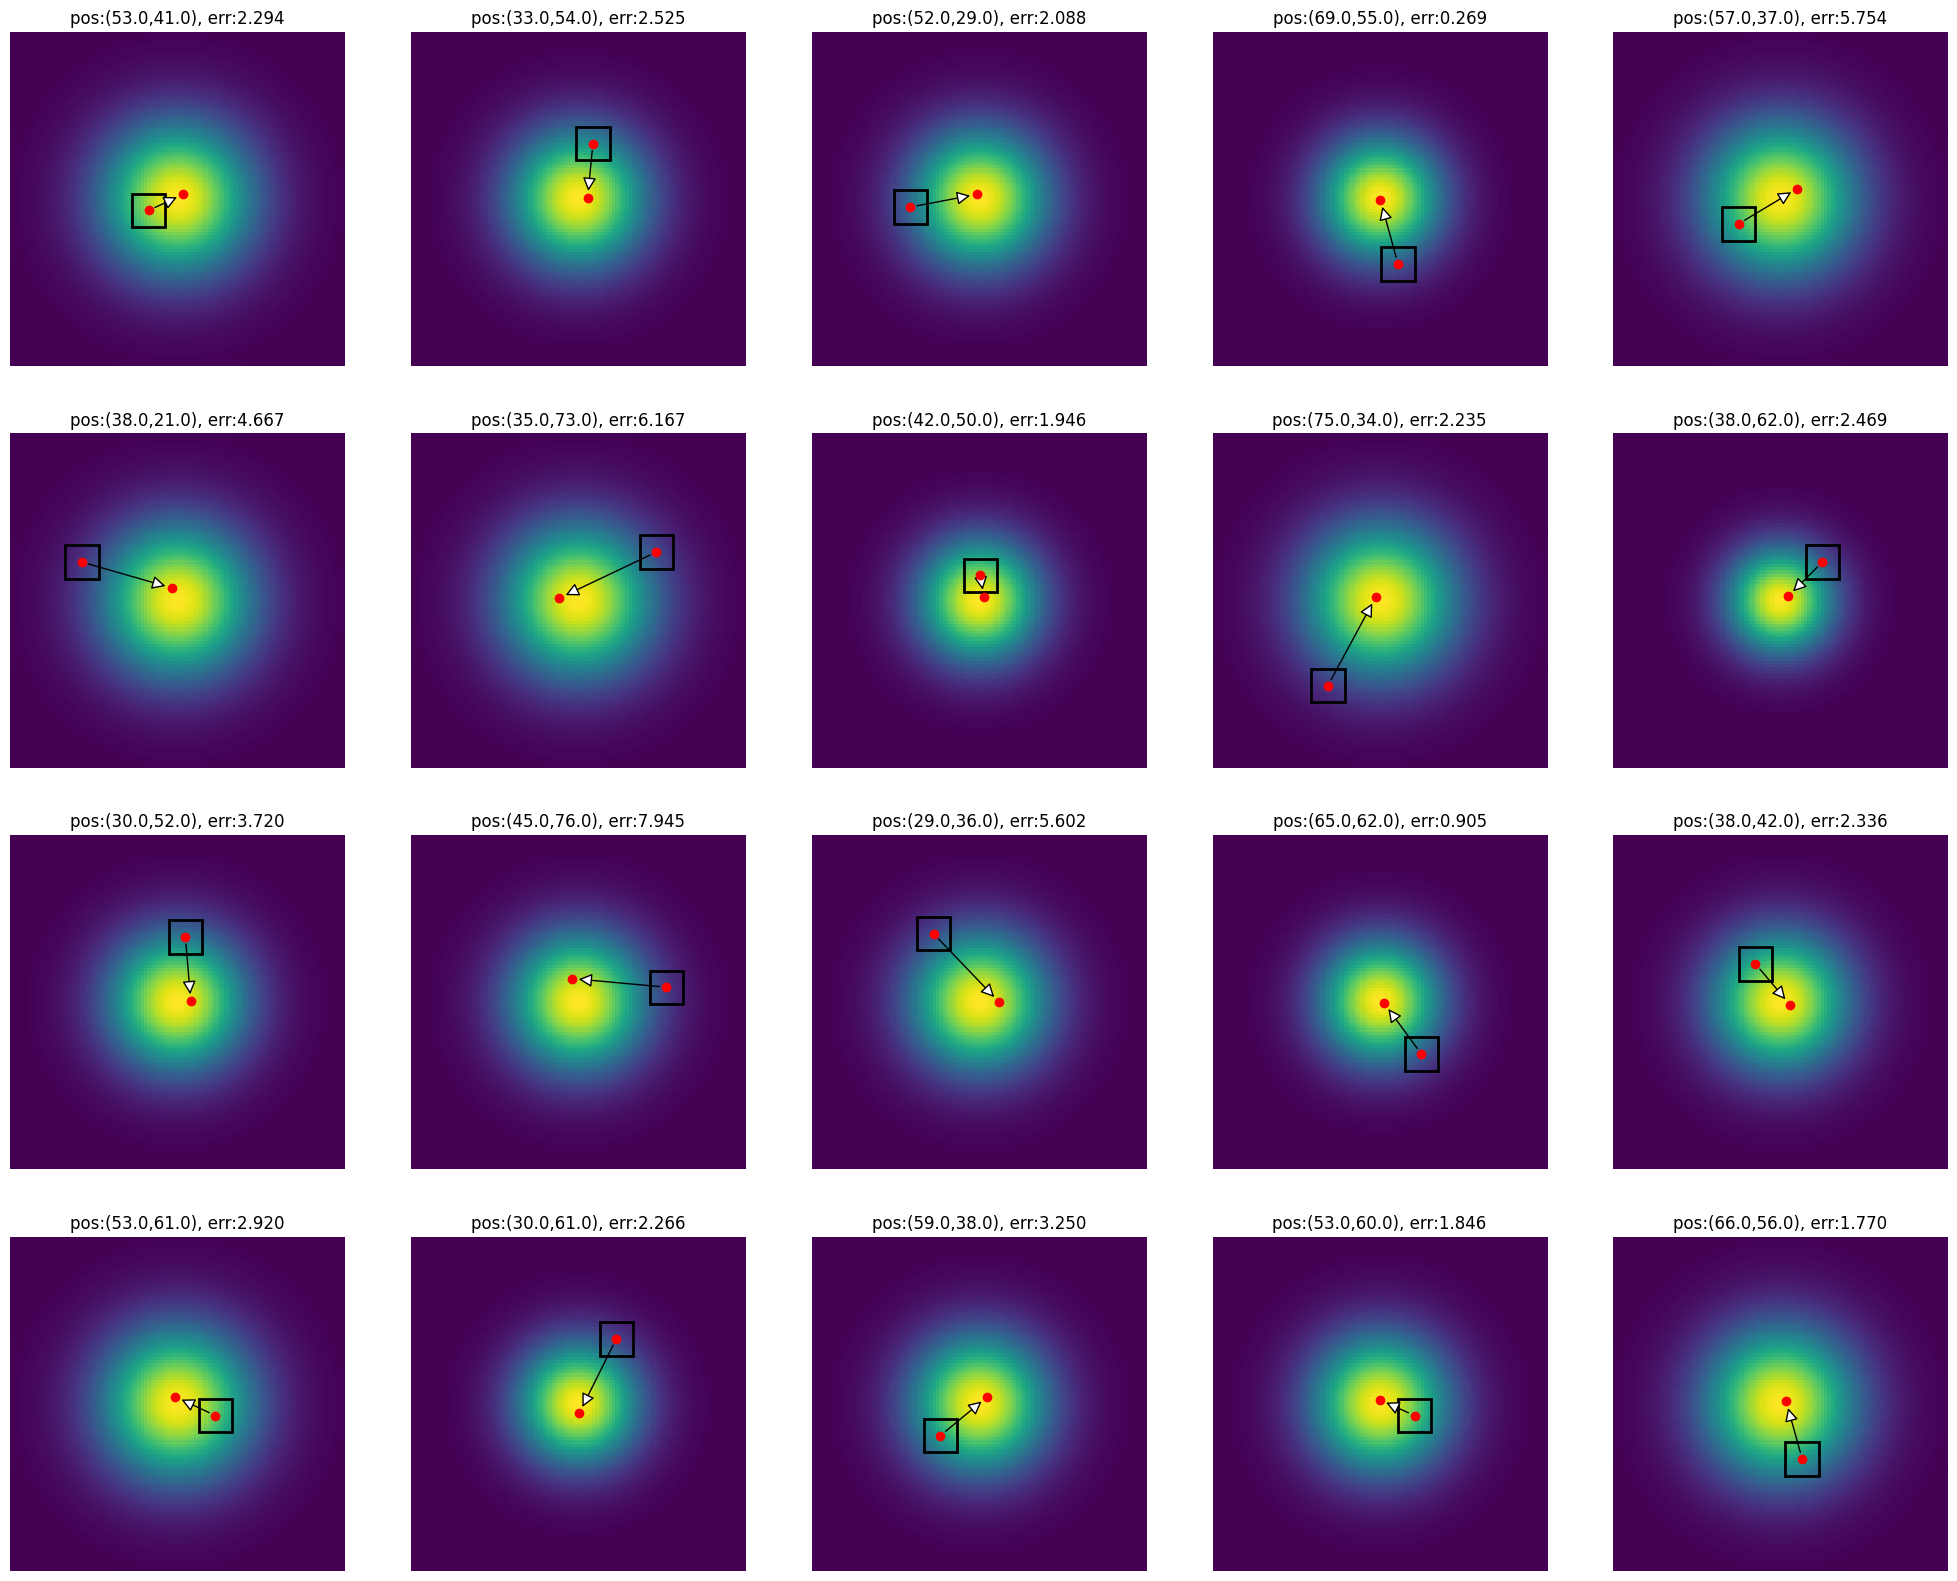

In [329]:
model = source_predictor_network()
model.load_state_dict(torch.load('./output/source_predictor.pth'))
evaluate_source_predictor(model, X, y, training_maps)

## Diffusion Field Environment

### 1. Diffusion Field Class

In [5]:
class SpatialDiffusionField():
    def __init__(self, data={}):
        self.n_step = 0
        self.snapshots = data['snapshots']
        self.isolated_fields = data['isolated_fields']
        self.sources = data['sources']
        self.src_pos = [src['position'] for src in self.sources]
        self.load_params(data['metadata'])
        self.field = self.snapshots[0]
       
    def load_params(self, params):
        self.params = params
        self.dx, self.dy, self.vx, self.vy = params["dx"], params["dy"], params["vx"], params["vy"]
        self.dt, self.k = params["dt"], params["k"]

    def step(self):
        self.n_step += 1
        self.field = self.snapshots[self.n_step]

    def reset(self):
        self.field = self.snapshots[0]
        self.n_step = 0

### 2. Agent Field Class

In [6]:
class AgentField():
    def __init__(self, size=100, vs_hsize=5, params={}):
        self.size = size
        self.vs_hsize = vs_hsize
        self.load_params(params)
        self.vs_field = np.zeros((self.size,self.size))
        self.visited_field = np.zeros((self.size,self.size))
        self.curr_pos = None
        
    def load_params(self, params):
        self.params = params
        self.dx, self.dy, self.vx, self.vy = params["dx"], params["dy"], params["vx"], params["vy"]
        self.dt, self.k = params["dt"], params["k"]

    def update(self, env_field, pos):
        min_x, max_x = pos[0] - self.vs_hsize, pos[0] + self.vs_hsize + 1
        min_y, max_y = pos[1] - self.vs_hsize, pos[1] + self.vs_hsize + 1
        self.curr_pos = pos
        self.vs_field[min_y:max_y, min_x:max_x] = env_field[min_y:max_y, min_x:max_x]
        self.visited_field[min_y:max_y, min_x:max_x] = 1
        self.update_viewscope_field()
        
    def get_visited_field_image(self):
        return np.expand_dims((self.visited_field * 255).astype('uint8'), axis=-1)

    def update_viewscope_field(self):
        updated_u = self.vs_field.copy()
        u_k = self.vs_field.copy()
        for i in range(1, self.size - 1):
            for j in range(1, self.size - 1):
                updated_u[j, i] = u_k[j, i] + self.k * (self.dt / self.dx ** 2) * \
                    ((u_k[j + 1, i] + u_k[j - 1, i] +
                        u_k[j, i + 1] + u_k[j, i - 1] - 4 * u_k[j, i])) + \
                    self.vx * (self.dt / self.dx) * ((u_k[j + 1, i] - u_k[j, i])) + self.vy * (self.dt / self.dy) * \
                    (u_k[j, i + 1] - u_k[j, i])
        self.vs_field = updated_u

    def reset(self, pos=None):
        self.vs_field = np.zeros((self.size,self.size))
        self.visited_field = np.zeros((self.size,self.size))
        self.curr_pos = pos

### 3. Simulation Environment

In [7]:
import gym
import random
import copy
import numpy as np

ACTION_MAP = {0:"left",1:"right",2:"up",3:"down",4:"stay",5:"up-left",6:"up-right",7:"down-left",8:"down-right"}
ACTIONS = ["left", "right", "up", "down", "stay", "up-left", "up-right", "down-left", "down-right"]
ACTION_OFFSET = np.array([[-1,0],[1,0],[0,-1],[0,1],[0,0],[-1,-1],[1,-1],[-1,1],[1,1]])

class DiffusionFieldEnvironment(gym.Env):
    def __init__(self, env_name='2-src-1', data_path='./maps.pickle', max_num_steps=299, size=100, vs_hsize=5, src_thresh=8):
        metadata = {'render.modes': ['human']}
        super(DiffusionFieldEnvironment,
              self).__init__()
        self.name = env_name
        with open(data_path, 'rb') as handle:
            self.data = (pickle.load(handle))[self.name]
                    
        self.max_num_steps = max_num_steps
        self.size = size
        self.vs_hsize = vs_hsize
        self.src_thresh = src_thresh

        self.env_field = SpatialDiffusionField(data=self.data)
        self.agent_field = AgentField(size=self.size, vs_hsize=self.vs_hsize, params=self.env_field.params)
        self.detected_sources = []
        self.num_steps = 0
        self.agent_position, self.agent_trajectory, self.agent_gradients = None, [], [0.0, 0.0]

        self.rewards, self.mapping_errors, self.concentrations, self.gradients_0, self.gradients_1 = [], [], [], [], []
        self.action_space_map, self.actions, self.action_space = ACTION_MAP, ACTIONS, gym.spaces.Discrete(9)

        low = np.array([0.0, -100.0, -100.0])
        high = np.array([25.0, 100.0, 100.0])
        self.observation_space = gym.spaces.Box(low, high, dtype=np.float64)
        self.init_mapping_error = np.sum(self.env_field.field)

    def calculate_gradients(self, r):
        dz_dx = (self.env_field.field[r[1], r[0] + 1] -
                 self.env_field.field[r[1], r[0] - 1]) / (2 * self.env_field.dx)
        dz_dy = (self.env_field.field[r[1] + 1, r[0]] -
                 self.env_field.field[r[1] - 1, r[0]]) / (2 * self.env_field.dy)
        return np.array([dz_dx, dz_dy])
    
    def get_formation_states(self, r):
        formation_pos = np.array([[r[1]-self.vs_hsize,r[1]-self.vs_hsize],[r[1]+self.vs_hsize,r[1]-self.vs_hsize],\
                                 [r[1]+self.vs_hsize,r[1]+self.vs_hsize],[r[1]-self.vs_hsize,r[1]+self.vs_hsize]])
        formation_state = [self.vs_hsize*2+1]
        for pos in formation_pos:
            formation_state.append(self.env_field.field[pos[1],pos[0]]) # concentration
            formation_state.append((self.env_field.field[pos[1],pos[0]-1]+self.env_field.field[pos[1],pos[0]+1])/(2 * self.env_field.dx)) # grad-x
            formation_state.append((self.env_field.field[pos[1]-1,pos[0]]+self.env_field.field[pos[1]+1,pos[0]])/(2 * self.env_field.dy)) # grad-y
        return formation_state

    def step(self, action_id):
        (hit_wall, next_position) = self.get_next_position(action_id)
        if (hit_wall):
            next_position = self.agent_position

        # Update field state
        self.env_field.step()
        self.agent_field.update(env_field=self.env_field.field, pos=next_position)

        # Update Mapping error
        curr_mapping_error = self.calculate_mapping_error()
        self.mapping_errors.append(curr_mapping_error)

        # Update number of steps
        self.num_steps += 1

        # Update agent variables
        self.agent_position = next_position
        self.agent_trajectory.append(self.agent_position)

        # Get concentration
        self.concentration = self.env_field.field[self.agent_position[1], self.agent_position[0]]
        self.agent_gradients = self.calculate_gradients(self.agent_position)
        
        observations = {"location":next_position, "field_size":self.size, "formation_states": self.get_formation_states(next_position),\
                        "sources":self.env_field.src_pos, "source_size":40}
        # Check if source is reached
        source_detected, detected_src_idx = self.source_detected(self.concentration, self.agent_gradients[0], self.agent_gradients[1])
        if source_detected and (not np.isin(self.detected_srcs,detected_src_idx).any()):
            self.detected_src_idx = detected_src_idx
            self.detected_srcs.append(detected_src_idx)
            observations["source_found_idx"] = detected_src_idx
            observations["source_found"] = self.env_field.src_pos[self.detected_src_idx]
            observations["source_field"] = self.env_field.isolated_fields[self.detected_src_idx]
        else:
            self.detected_src_idx = None        

        # Check for termination criteria
        done = False
        if (self.num_steps >= self.max_num_steps):
            done = True
        reward = 0
        
        # Record field values
        self.concentrations.append(self.concentration)
        self.gradients_0.append(self.agent_gradients[0])
        self.gradients_1.append(self.agent_gradients[1])
        
        next_state = [self.concentration, self.agent_gradients[0], self.agent_gradients[1]]
        return (next_state, reward, done, observations)

    def reset(self, pos=None):
        # Reset agent related params
        self.num_steps = 0
        self.agent_position, self.agent_trajectory, self.agent_gradients = self.choose_random_start_position(fixed_pos=pos), [], [0.0, 0.0]
        self.rewards, self.mapping_errors, self.concentrations, self.gradients_0, self.gradients_1 = [], [], [], [], []
        self.env_field.reset()
        self.agent_field.reset(pos=self.agent_position)
        self.agent_field.update(self.env_field.field, self.agent_position)
        self.concentration = self.env_field.field[self.agent_position[1], self.agent_position[0]]
        self.agent_gradients = self.calculate_gradients(self.agent_position)

        # Record field values
        self.concentrations.append(self.concentration)
        self.gradients_0.append(self.agent_gradients[0])
        self.gradients_1.append(self.agent_gradients[1])

        self.detected_src_idx = None
        self.detected_srcs = []
        observations = {"location": self.agent_position, "field_size":self.size, "formation_states": self.get_formation_states(self.agent_position), \
                        "sources": self.env_field.src_pos, "source_size":40}
        next_state = [self.concentration, self.agent_gradients[0], self.agent_gradients[1]]
        return next_state, observations

    def choose_random_start_position(self, fixed_pos=None):
        possible_starts = [[10,10], [90, 90], [10, 90], [90, 10]]
        return fixed_pos if fixed_pos is not None else random.choice(possible_starts)
    
    # def source_detected(self, con, grad_x, grad_y):
    #     detected = con >= self.src_thresh
    #     if detected:
    #         detected_src_idx = np.argmin(np.linalg.norm(self.env_field.src_pos - self.agent_position, axis=1))
    #         return True, detected_src_idx
    #     else:
    #         return False, None
    
    def source_detected(self, con, grad_x, grad_y):
        src_distance = np.linalg.norm(self.env_field.src_pos - self.agent_position, axis=1)
        if (src_distance<self.src_thresh).any():
            detected_src_idx = np.argmin(src_distance)
            return True, detected_src_idx
        else:
            return False, None

    def get_next_position(self, action_id):
        # Create a deepcopy of current state
        next_state = copy.deepcopy(self.agent_position)
        next_state = np.add(next_state, ACTION_OFFSET[action_id])

        # Check for collisions
        hit_wall = False
        if ((next_state[0] < (0 + self.agent_field.vs_hsize) or
             next_state[0] >= (self.agent_field.size - self.agent_field.vs_hsize)) or
            ((next_state[1] < (0 + self.agent_field.vs_hsize) or
              next_state[1] >= (self.agent_field.size - self.agent_field.vs_hsize)))):
            # If the view scope is out of the field, hit_wall is set to True
            hit_wall = True

        return (hit_wall, next_state)

    def calculate_mapping_error(self):
        return np.sum(np.abs(self.agent_field.vs_field - self.env_field.field))

    def render(self, mode="human"):
        pass

In [22]:
# plot env_field and mapping_error from all envs
def plot_environment_state(env, name, save=False):    
    import matplotlib.patches as patches

    fig_learning, fig_learning_axes = plt.subplots(1, 2, figsize=(15, 5))

    fig_learning_axes[0].set_title(name)
    fig_learning_axes[0].set_aspect("equal")
    fig_learning_axes[1].set_title("Mapping Error")
    fig_learning_axes[1].set_xlim([0, env.max_num_steps])

    # Plot 1: Environment End state
    fig_learning_axes[0].imshow(env.env_field.field)

    traj_r = [position[0] for position in env.agent_trajectory]
    traj_c = [position[1] for position in env.agent_trajectory]
    fig_learning_axes[0].plot(traj_r, traj_c, '.', color='black')

    # print(self.agent_trajectory)
    fig_learning_axes[0].plot(
        env.agent_trajectory[0][0], env.agent_trajectory[0][1], '*', color='red')

    view_scope_box = patches.Rectangle(
        (env.agent_trajectory[-1][0] - env.vs_hsize,
         env.agent_trajectory[-1][1] - env.vs_hsize), env.vs_hsize*2+1, env.vs_hsize*2+1,
        linewidth=2, edgecolor='r', facecolor='none')
    fig_learning_axes[0].add_patch(view_scope_box)

    # Plot 2: Mapping Error
    fig_learning_axes[1].plot(env.mapping_errors, '.-')
    if save:
        plt.savefig(f'outputs/experiment_trajectory_{name}.png', facecolor='white', transparent=False)
    plt.show()

def plot_env_subplot(env, ax, name):
    import matplotlib.patches as patches
    ax.set_title(name)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.imshow(env.env_field.field)
    traj_r = [position[0] for position in env.agent_trajectory]
    traj_c = [position[1] for position in env.agent_trajectory]
    ax.plot(traj_r, traj_c, '.', color='black')
    ax.plot(env.agent_trajectory[0][0], env.agent_trajectory[0][1], '*', color='red')
    view_scope_box = patches.Rectangle(
        (env.agent_trajectory[-1][0] - env.vs_hsize,
         env.agent_trajectory[-1][1] - env.vs_hsize), env.vs_hsize*2+1, env.vs_hsize*2+1,
        linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(view_scope_box)

## Diffusion Field Exploration Agents

In [9]:
class BaseHandler():
    def __init__(self, params):
        pass
    def get_next_action(self, state, params):
        pass
    def reset(self, source_found=None, params={}):
        pass
    def get_action_by_dest(self, pos, dest):
        if (pos == dest).all():
            return 4, True
        dx = dest[0] - pos[0]
        dy = dest[1] - pos[1]
        steps = abs(dx) if abs(dx) > abs(dy) else abs(dy)
        offset = np.array([int(dx/steps), int(dy/steps)])
        action_id = np.where((ACTION_OFFSET==offset).all(1))[0][0]
        dest_reached = pos[0]+offset[0]==dest[0] and pos[1]+offset[1]==dest[1]
        return action_id, dest_reached
    def bounded_vec(self, raw_vec, field_size=100, padding=0):
        return np.array([max(min(raw_vec[0], field_size-padding-2), padding), max(min(raw_vec[1], field_size-padding-2), padding)])

### 1. Field Exploration Component

In [6]:
class GameMasterExplorationHandler(BaseHandler):
    def __init__(self, params):
        self.sources = np.array(params['sources'])
        self.pos = np.array(params['location'])
        self.nearest_src_idx = np.argmin(np.linalg.norm(self.sources - self.pos, axis=1))
        self.target_src = self.sources[self.nearest_src_idx]
        self.sources = np.delete(self.sources, self.nearest_src_idx, axis=0)
        
    def get_next_action(self, state, params):
        if self.target_src is None:
            return 4, False # stay
        self.pos = np.array(params['location'])
        action_id, dest_reached = self.get_action_by_dest(self.pos, self.target_src)
        if dest_reached:
            self.reset()
        return action_id, dest_reached
    
    def reset(self, source_found=None, params={}):
        if len(self.sources) > 0:
            if (source_found is None) or (source_found==self.target_src):
                self.nearest_src_idx = np.argmin(np.linalg.norm(self.sources - self.pos, axis=1))
                self.target_src = self.sources[self.nearest_src_idx]
                self.sources = np.delete(self.sources, self.nearest_src_idx, axis=0)
            else:
                source_found_idx = np.where((self.sources==source_found).all(1))[0][0]
                self.sources = np.delete(self.sources, self.source_found_idx, axis=0)
        else:
            self.target_src = None

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

class ClusterBasedExplorationHandler(BaseHandler):
    def __init__(self, params):
        self.field_size = params['field_size']
        self.pos = np.array(params['location'])
        self.field = np.zeros((self.field_size,self.field_size))
        self.field_mask = np.zeros((self.field_size,self.field_size))
        self.field_clusters = np.zeros((self.field_size,self.field_size))
        self.generate_clustered_field()
        self.nearest_centroid_idx = np.argmin(np.linalg.norm(self.centroids - self.pos, axis=1))
        self.target_centroid = np.round(self.centroids[self.nearest_centroid_idx])
        self.dest_reached = False
        
    def generate_clustered_field(self, k=6):
        self.indices = np.argwhere(self.field_mask == 0)
        self.kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(self.indices)
        self.field_clusters = np.zeros((self.field_size,self.field_size))
        for idx, fieldIdx in enumerate(self.indices):            
            self.field_clusters[fieldIdx[0],fieldIdx[1]] = self.kmeans.labels_[idx]+1
        # plt.imshow(self.field_clusters)
        # plt.show()
        self.centroids = self.kmeans.cluster_centers_[:,::-1]
        self.labels = np.array(list(range(len(self.centroids))))
        
    def get_next_action(self, state, params):
        source_found = params["source_found"] if "source_found" in params.keys() else None        
        
        if source_found is not None:
            self.reset(source_found=source_found, params=params)
        elif  self.dest_reached:
            self.reset()
        if self.target_centroid is None:
            return 4, False # stay
        self.pos = np.array(params['location'])
        action_id, dest_reached = self.get_action_by_dest(self.pos, self.target_centroid)
        self.dest_reached = dest_reached
        return action_id, dest_reached
            
    def reset(self, source_found=None, params={}):
        if source_found is None:
            if len(self.centroids) > 1:
                self.field_mask[self.field_clusters==(self.labels[self.nearest_centroid_idx]+1)] = 1
                # plt.imshow(self.field_mask)
                # plt.show()
                self.centroids = np.delete(self.centroids, self.nearest_centroid_idx, axis=0)
                self.labels =  np.delete(self.labels, self.nearest_centroid_idx, axis=0)
                if len(self.centroids) > 0:
                    self.nearest_centroid_idx = np.argmin(np.linalg.norm(self.centroids - self.pos, axis=1))
                    self.target_centroid = np.round(self.centroids[self.nearest_centroid_idx])
            else:
                self.nearest_centroid_idx = None
                self.target_centroid = None
        else:
            detected_src_field = params["source_field"]
            self.source_size = params["source_size"]
            self.field_mask[detected_src_field>5] = 1
            self.field_mask[self.field_clusters==(self.labels[self.nearest_centroid_idx]+1)] = 1
            # print("--- Source Detected ---")
            # plt.imshow(self.field_mask)
            # plt.show()
            unvisited_size = self.field_size**2 - np.count_nonzero(self.field_mask)
            estimated_k = unvisited_size / self.source_size**2
            if estimated_k > 0.25 and (self.field_mask == 0).any():
                self.generate_clustered_field(k=np.maximum(2, int(estimated_k)))
                self.nearest_centroid_idx = np.argmin(np.linalg.norm(self.centroids - self.pos, axis=1))
                self.target_centroid = np.round(self.centroids[self.nearest_centroid_idx])
            else:
                self.indices = np.argwhere(self.field_mask == 0)
                self.target_centroid = None

In [11]:
class DestionationChooserExplorationHandler(BaseHandler):
    def __init__(self, params):
        pass
    def get_next_action(self, state, params):
        pass

### 2. Source Heading Component

In [12]:
from torch import nn
class DQN(nn.Module):
    def __init__(self, input_shape, hidden_size, n_actions):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape[0], hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, n_actions)
        )
    def forward(self, x):
        return self.net(x.float())

In [13]:
class GradientSourceHeadingHandler(BaseHandler):
    def __init__(self, params, k=2):
        self.k = k
        self.field_size = params['field_size']
    def get_next_action(self, state, params):
        grad_vec = np.array([state[1], state[2]])
        grad_vec_k = self.k * grad_vec / np.linalg.norm(grad_vec)
        position = np.array(params['location'])
        target_position = self.bounded_vec(position + grad_vec_k, field_size=self.field_size).round()
        action_id, dest_reached = self.get_action_by_dest(position, target_position)
        return action_id
    
class DQNSourceHeadingHandler(BaseHandler):
    def __init__(self, params):
        self.model_path = './output/experiments/dqn_src_heading.dat'
        self.device = 'cpu'
        self.net = DQN((3,), 512, 9).to(self.device)
        self.net.load_state_dict(torch.load(self.model_path))
    def get_next_action(self, state, params):
        state_v = torch.tensor(np.array([state], copy=False)).to(self.device)
        q_vals = self.net(state_v).data.cpu().numpy()[0]
        action_id = np.argmax(q_vals * action_probs)
        return action_id
    
class SourcePredictorHeadingHandler(BaseHandler):
    def __init__(self, params):
        self.model = source_predictor_network()
        self.model.load_state_dict(torch.load('./output/experiments/source_predictor.pth'))
        self.src_pos = None
    def get_next_action(self, state, params):
        self.pos = np.array(params['location'])
        if self.src_pos is not None:
            formation_states = params['formation_states']
            with torch.no_grad():
                src_offset = self.model(torch.tensor(formation_states, dtype=torch.float32)).numpy()
            self.src_pos = np.array([self.pos[0]+src_offset[0],self.pos[1]+src_offset[1]])
        action_id, dest_reached = self.get_action_by_dest(self.pos, self.src_pos)
        if dest_reached:
            self.src_pos = None
        return action_id
    

## Evaluating Cluster-Exploration Handler

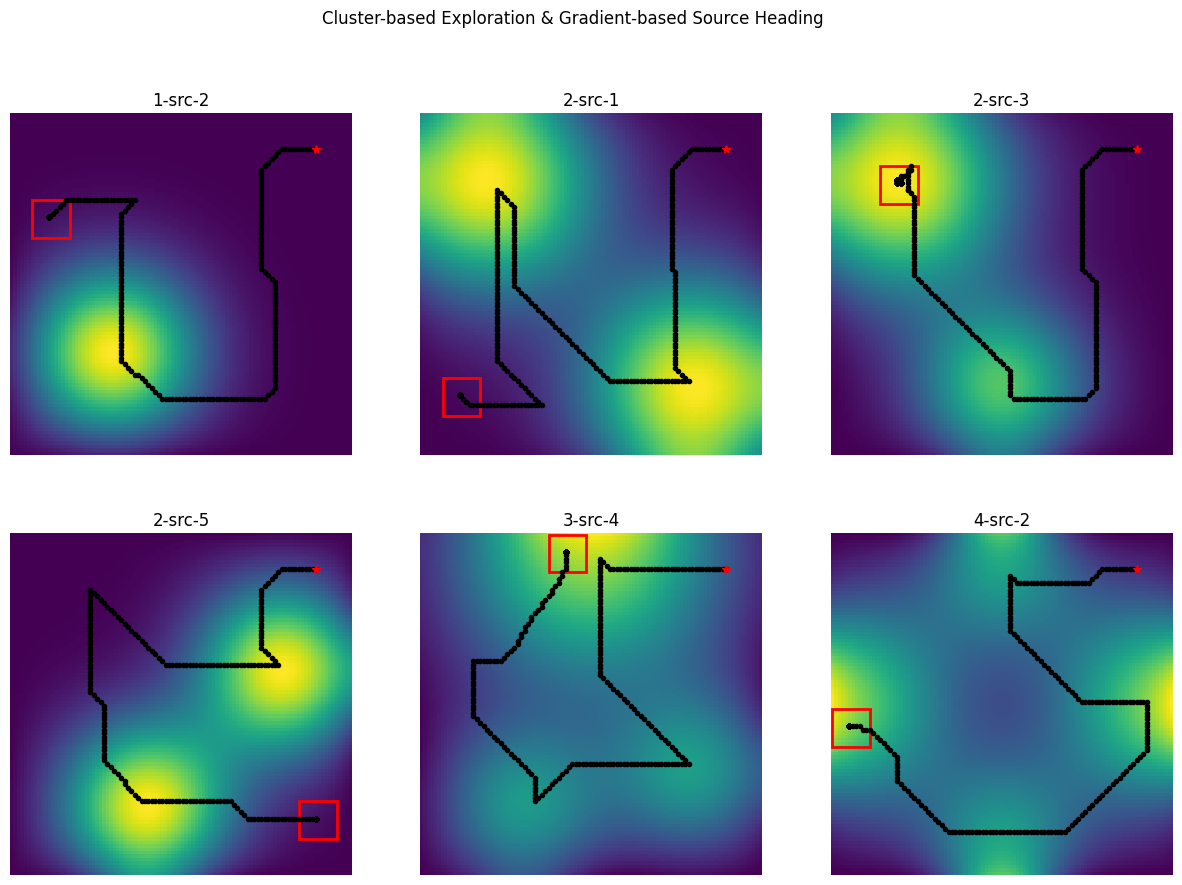

In [25]:
import pickle

selected_maps = ['1-src-2','2-src-1','2-src-3','2-src-5','3-src-4','4-src-2',]
fig, axes = plt.subplots(len(selected_maps)//3, 3, figsize=(15, 10))
fig.suptitle('Cluster-based Exploration & Gradient-based Source Heading')
for idx, name in enumerate(selected_maps):
    # print(f'MAP: {name}')
    env = DiffusionFieldEnvironment(env_name=name, src_thresh=4)
    state, obsr  = env.reset(pos=[90,10])
    steps = 0
    z_thresh = 5
    exploration_handler = ClusterBasedExplorationHandler(obsr)
    src_heading_handler = GradientSourceHeadingHandler(obsr)
    explore_mode = True
    new_target_reached = True
    while True:
        # print('EXPLORE' if explore_mode else 'SOURCE-HEADING')
        # print(f'STATE: {state}')
        if explore_mode:
            action_id, dest_reached = exploration_handler.get_next_action(state, obsr)
            new_target_reached = new_target_reached or dest_reached 
            state, reward, done, obsr = env.step(action_id)
            if state[0] > z_thresh and new_target_reached:
                explore_mode = False 
        else:
            action_id = src_heading_handler.get_next_action(state, obsr)    
            state, reward, done, obsr = env.step(action_id)
            if "source_found" in obsr.keys():
                explore_mode = True
                new_target_reached = False   
        if done:
            plot_env_subplot(env, axes[idx//3,idx%3], name)
            # plt.imshow(env.agent_field.visited_field)
            break
        steps += 1
plt.show()

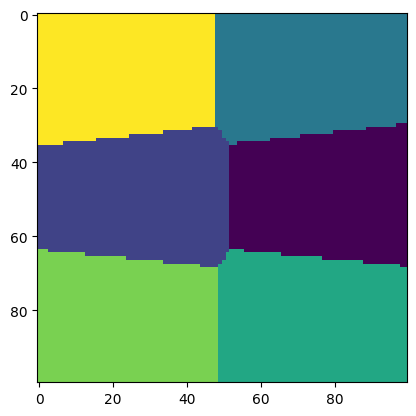

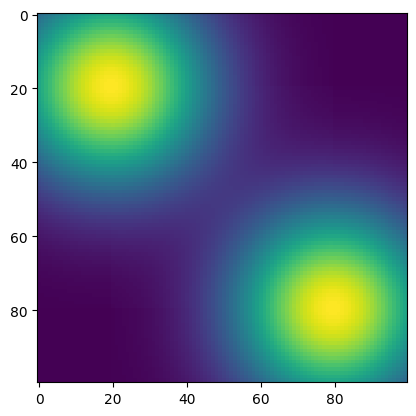

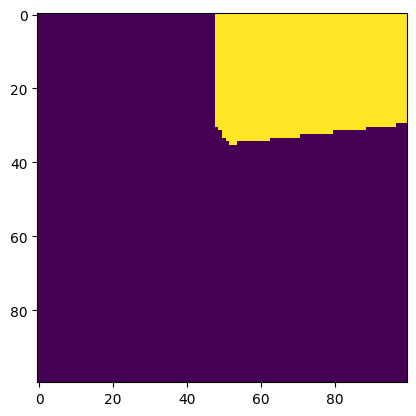

--- Source Detected ---


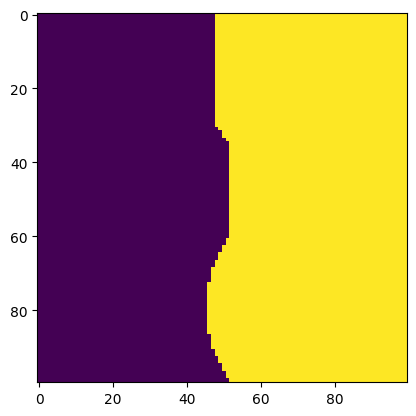

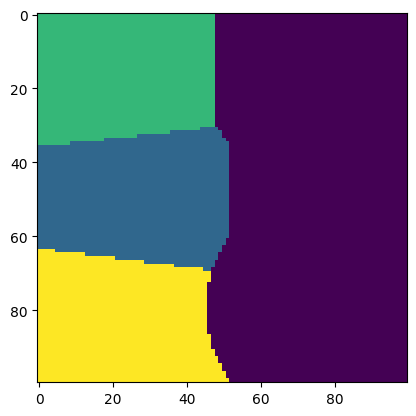

--- Source Detected ---


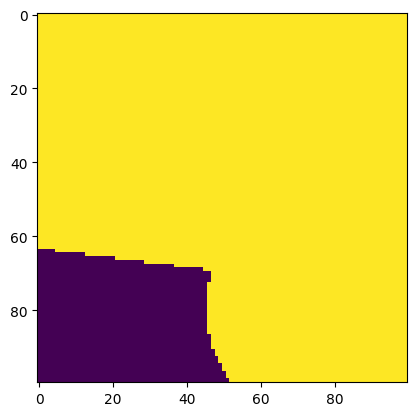

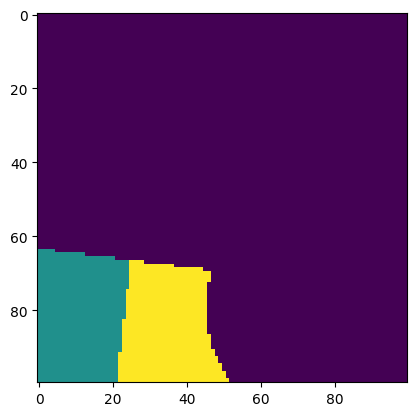

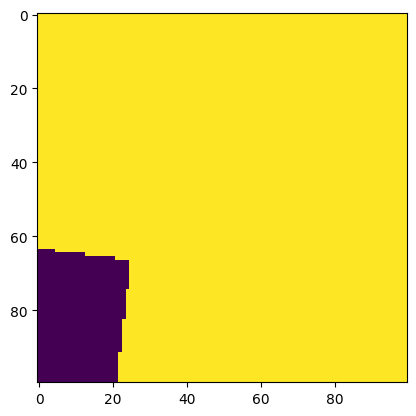

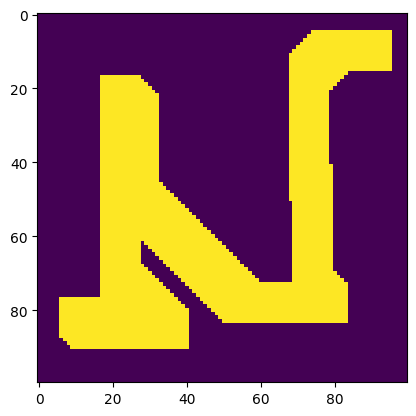

In [14]:
import pickle

env = DiffusionFieldEnvironment(env_name='2-src-1', src_thresh=4)
state, obsr  = env.reset(pos=[90,10])
steps = 0
z_thresh = 5
exploration_handler = ClusterBasedExplorationHandler(obsr)
src_heading_handler = GradientSourceHeadingHandler(obsr)
explore_mode = True
new_target_reached = True
plt.imshow(env.env_field.field)
plt.show()
while True:
    # print('EXPLORE' if explore_mode else 'SOURCE-HEADING')
    # print(f'STATE: {state}')
    if explore_mode:
        action_id, dest_reached = exploration_handler.get_next_action(state, obsr)
        new_target_reached = new_target_reached or dest_reached 
        state, reward, done, obsr = env.step(action_id)
        if state[0] > z_thresh and new_target_reached:
            explore_mode = False 
    else:
        action_id = src_heading_handler.get_next_action(state, obsr)    
        state, reward, done, obsr = env.step(action_id)
        if "source_found" in obsr.keys():
            explore_mode = True
            new_target_reached = False   
    if done:
        # plot_env_subplot(env, axes[idx//3,idx%3], name)
        plt.imshow(env.agent_field.visited_field)
        break
    steps += 1